# Quantum-Inspired Image Classification using QCNNs

### Environment Setup

In [ ]:
!pip3 install --upgrade pip
!pip3 install tensorflow==2.7.0
!pip3 install -U tensorflow-quantum 
!pip3 install seaborn matplotlib
!pip install pydot graphviz

# Supporting libraries for tensorflow quantum
!pip3 install googleapis-common-protos==1.52.0 google-api-core==1.21.0 google-auth==1.18.0 google-api-python-client==1.8.0 grpcio==1.34.1 protobuf==3.17.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.6/489.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.1/463.1 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.7 MB/s eta 0:00:00
  Obtaining dependency information for MarkupSafe>=2.1.1 from https://files.pythonhosted.org/packages/de/e2/32c14301bb023986dff527a49325b6259cab4ebb4633f69de54af312fc45/MarkupSafe-2.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Not uninstalling tensorflow-estimator at /shared-libs/python3.8/py/lib/python3.8/site-packages, outside environment /root/venv
    Can't uninstall 'tensorflow-estimator'. No f

### Import libraries and tools

In [ ]:
# Tensorflow for Quantum
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

# Cirq simulator
import cirq
import sympy
import numpy as np
import collections

# Visualization Tools
%matplotlib inline
import pydot
import graphviz
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from tensorflow.keras.utils import plot_model

2023-08-26 20:21:48.000798: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-26 20:21:48.000834: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-26 20:21:53.912458: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-26 20:21:53.912529: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-26 20:21:53.912551: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-4029068e-263e-4c12-9932-d3ac72036324): /proc/driver/nvidia/version does not exist
2023-08-26 20:21:53.912928: I tensorfl

### Load the Dataset, perform Preprocessing

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the images from [0,255] to the [0, 1] range, generally improves performance
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

x_train= tf.cast(x_train, tf.float32)
x_test=tf.cast(x_test, tf.float32)

print("# training examples:", len(x_train))
print("# test examples:", len(x_test))

11501568/11490434 [==============================] - 0s 0us/step
2023-08-26 20:21:54.701420: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 376320000 exceeds 10% of free system memory.
2023-08-26 20:21:54.862897: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
# training examples: 60000
# test examples: 10000
2023-08-26 20:21:55.010138: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62720000 exceeds 10% of free system memory.


In [ ]:
# Downscale the image to fit in Quantum Simulator
x_train = tf.image.resize(x_train[:], (8,8)).numpy()
x_test = tf.image.resize(x_test[:], (8,8)).numpy()

y_train = y_train[:]
y_test = y_test[:]

7


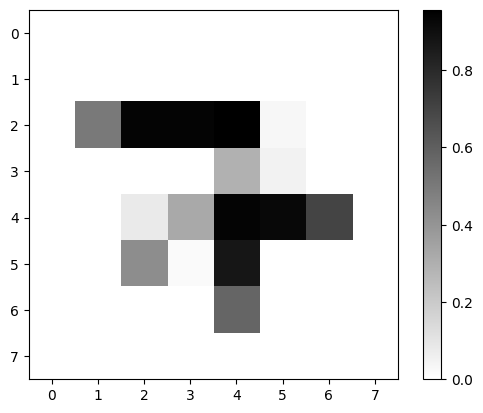

In [ ]:
# Data visualization
print(y_train[38])
fig = plt.figure()
plt.imshow(x_train[38, :, :, 0], cmap='gray_r')
plt.colorbar()
fig.savefig('visualization', dpi=300)

7
2023-08-26 20:21:56.276286: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 376320000 exceeds 10% of free system memory.
2023-08-26 20:21:56.435990: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


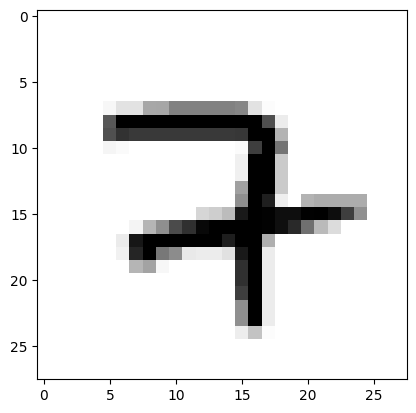

In [ ]:
# Normalize the Data
(x_train_new, y_train_new), (x_test_new, y_test_new) = tf.keras.datasets.mnist.load_data()
x_train_new, x_test_new = x_train_new[..., np.newaxis]/255.0, x_test_new[..., np.newaxis]/255.0
x_train_new = tf.cast(x_train_new, tf.float32)
x_test_new = tf.cast(x_test_new, tf.float32)
print(y_train_new[38])

fig = plt.figure()
plt.imshow(x_train_new[38, :, :, 0], cmap = 'gray_r')

### Convolution Neural Networks

In [ ]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(16, (2,2), activation='relu', input_shape=(width, height, 1)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 16)          80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 64)                9280      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 10,010
Trainable params: 10,010
Non-trainable params: 0
____________________________________________________

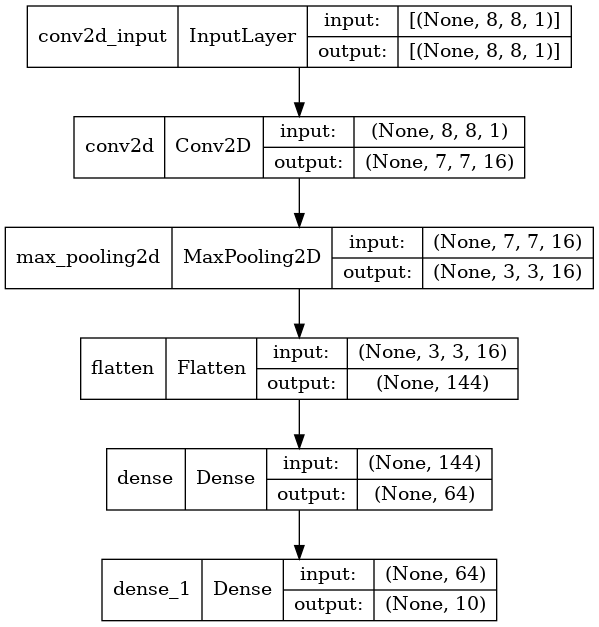

In [ ]:
plot_model(cnn_model, to_file='cnn.png', show_shapes=True)

In [ ]:
cnn_model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_history = cnn_model.fit(x_train, y_train,steps_per_epoch=650,
                        validation_data=(x_test, y_test), 
                        epochs=30, batch_size=16)

Epoch 1/30
650/650 [==============================] - 3s 3ms/step - loss: 1.1167 - accuracy: 0.6748 - val_loss: 0.5478 - val_accuracy: 0.8376
Epoch 2/30
650/650 [==============================] - 3s 4ms/step - loss: 0.5356 - accuracy: 0.8317 - val_loss: 0.4459 - val_accuracy: 0.8594
Epoch 3/30
650/650 [==============================] - 3s 4ms/step - loss: 0.4475 - accuracy: 0.8562 - val_loss: 0.3989 - val_accuracy: 0.8734
Epoch 4/30
650/650 [==============================] - 2s 3ms/step - loss: 0.3993 - accuracy: 0.8694 - val_loss: 0.3740 - val_accuracy: 0.8789
Epoch 5/30
650/650 [==============================] - 3s 4ms/step - loss: 0.3723 - accuracy: 0.8766 - val_loss: 0.3482 - val_accuracy: 0.8882
Epoch 6/30
650/650 [==============================] - 2s 3ms/step - loss: 0.3811 - accuracy: 0.8766 - val_loss: 0.3417 - val_accuracy: 0.8894
Epoch 7/30
650/650 [==============================] - 3s 4ms/step - loss: 0.3594 - accuracy: 0.8823 - val_loss: 0.3276 - val_accuracy: 0.8989
Epoch 

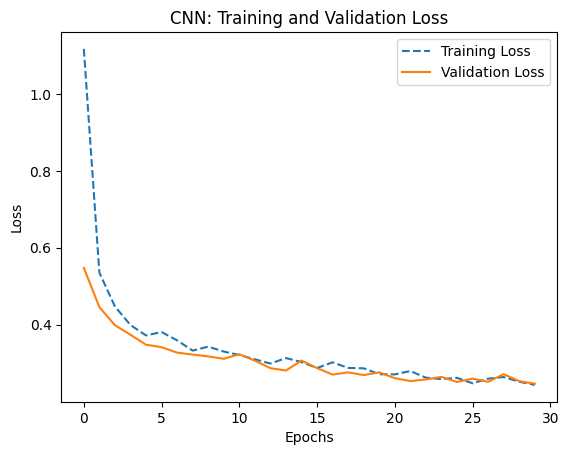

In [ ]:
plt.plot(cnn_history.history['loss'], label='Training Loss', linestyle='dashed')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', linestyle='solid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("CNN: Training and Validation Loss")
plt.show()

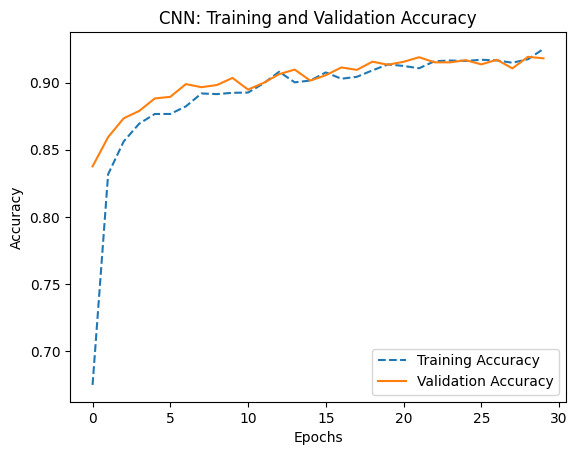

In [ ]:
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', linestyle='dashed')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', linestyle='solid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("CNN: Training and Validation Accuracy")
plt.show()

In [ ]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 0.2468 - accuracy: 0.9181 - 534ms/epoch - 2ms/step


In [ ]:
cnn_model.save("cnn_model.keras")

### Quantum Convolutional Neural Network

Setup the Quantum Circuits by generating qubits. Map the input data to circuit and apply RX gate on each qubit

     _next_qubit_set(self, original_size, next_size, qubits): Divides qubits into sets for the next convolutional layer.
     _get_new_param(self): Generates and stores a new learnable parameter.
    _QConv(self, step, target, qubits): Applies learnable gates for a quantum convolutional layer.
    QCNN_layer_gen(self): Generates the quantum convolutional layer circuit structure.
    build(self, input_shape): Builds the QConv layer by initializing weights and circuits based on input shape.
    forward_pass(self, inputs): Implements the forward pass through the QConv layer.
    single_depth_QCNN(self, input_data, controller, circuit_inputs): Computes the output of a single quantum convolutional layer.

In [ ]:
class QConv(tf.keras.layers.Layer):

    # Initializations
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    # Get the next set of qubits for quantum convolution 
    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    # Returns a new learnable parameter symbol and keeps track of learning parameters(Initialize Params)
    def _get_new_param(self):
        new_param = sympy.symbols(f"q{len(self.learning_params)}")
        self.learning_params.append(new_param)
        return new_param
    
    # Apply learnable gates(CZ and CX gates) for each convolutional layer
    def _QConv(self, step, target, qubits):
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        
    
    # Generate Quantum CNN Layer
    def QCNN_layer_gen(self):

        # Valid filter size: 2^n
        pixels = self.filter_size**2
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")

        # Create a grid containing qubits: filter*filter
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)

        # Map input data to circuits and apply RX Gate on each qubit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('X0%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))

        # Finally, apply Learnable Gates to the Cirq (Quantum Circuit)
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))] # calculate step-size
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))

        # Merge the circuits: Input Circuit + QCNN Circuit
        full_circuit = cirq.Circuit() # Single Quantum Circuit to represent the entire Quantum Convolutional Layer
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)

        # Save the circuit for later use
        self.circuit = full_circuit 
        # Save the parans for later use
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])

    # Set up dims and params based on input
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        
        # The number of times which the kernel will pass on the image
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kernel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        # Convert the circuit to tensors
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
        
    # Loop through each sliding position (i, j) and collect slices from the input tensor.
    def forward_pass(self, inputs):
        # Input shape: [N, width, height, channel]
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)  

        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        
        # total input circuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        outputs = []

        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            
        output_tensor = tf.stack(outputs, axis=3)
        # Ensure the values are in range [-1,1]
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        return self.activation(output_tensor)
          
    # Computes the output of single convolutional depth in QCNN
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
    
        # Reformat the input data
        input_data = tf.concat([input_data, controller], 1)
        # Take the inputs along with params and feed to QCNN
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)
        

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


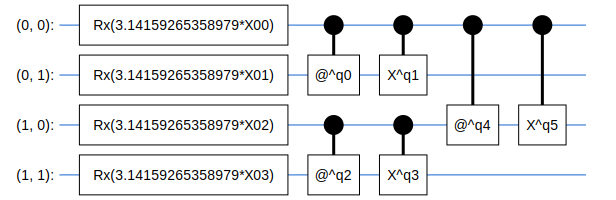

In [ ]:
SVGCircuit(QConv(filter_size=2, depth=2, activation='relu').circuit)

In [ ]:
qcnn_model = models.Sequential()

qcnn_model.add(QConv(filter_size=2, depth=16, activation='relu', input_shape=(width, height, 1)))
#qcnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # MaxPooling layer for down-sampling

qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(64, activation='relu'))
qcnn_model.add(layers.Dense(10, activation='softmax'))

In [ ]:
qconv_layer = QConv(filter_size=2, depth=16, activation='relu')

# Calculate the number of qubits
num_qubits = qconv_layer.filter_size ** 2

# Print the number of qubits
print("Number of qubits used:", num_qubits)

Number of qubits used: 4


In [ ]:
qcnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 q_conv_1 (QConv)            (None, 8, 8, 1)           96        
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 4,906
Trainable params: 4,906
Non-trainable params: 0
_________________________________________________________________


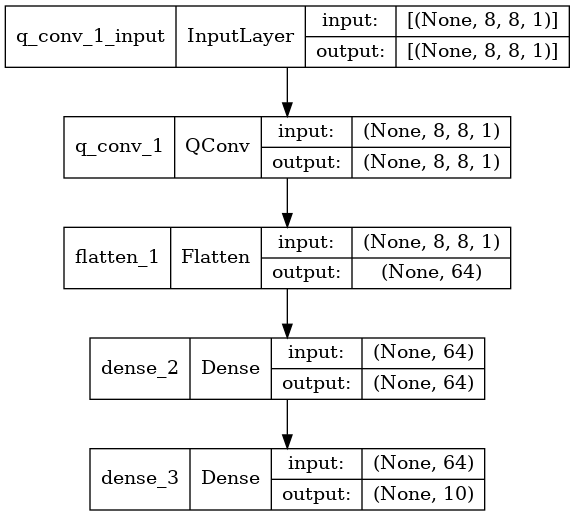

In [ ]:
plot_model(qcnn_model, to_file='qcnn.png', show_shapes=True)

In [ ]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

qcnn_history = qcnn_model.fit(x_train, y_train, steps_per_epoch=650,
                        validation_data=(x_test, y_test), 
                        epochs=30, batch_size=16)

Epoch 1/30
650/650 [==============================] - 2s 3ms/step - loss: 1.1873 - accuracy: 0.6895 - val_loss: 0.6737 - val_accuracy: 0.8077
Epoch 2/30
650/650 [==============================] - 2s 3ms/step - loss: 0.6257 - accuracy: 0.8145 - val_loss: 0.5365 - val_accuracy: 0.8408
Epoch 3/30
650/650 [==============================] - 2s 4ms/step - loss: 0.5243 - accuracy: 0.8409 - val_loss: 0.4850 - val_accuracy: 0.8546
Epoch 4/30
650/650 [==============================] - 2s 3ms/step - loss: 0.4813 - accuracy: 0.8537 - val_loss: 0.4578 - val_accuracy: 0.8614
Epoch 5/30
650/650 [==============================] - 2s 4ms/step - loss: 0.4582 - accuracy: 0.8621 - val_loss: 0.4285 - val_accuracy: 0.8679
Epoch 6/30
650/650 [==============================] - 2s 3ms/step - loss: 0.4287 - accuracy: 0.8676 - val_loss: 0.4034 - val_accuracy: 0.8777
Epoch 7/30
650/650 [==============================] - 2s 3ms/step - loss: 0.4057 - accuracy: 0.8761 - val_loss: 0.3877 - val_accuracy: 0.8842
Epoch 

In [ ]:
test_loss, test_acc = qcnn_model.evaluate(x_test, y_test, verbose=2)

313/313 - 1s - loss: 0.2596 - accuracy: 0.9173 - 641ms/epoch - 2ms/step


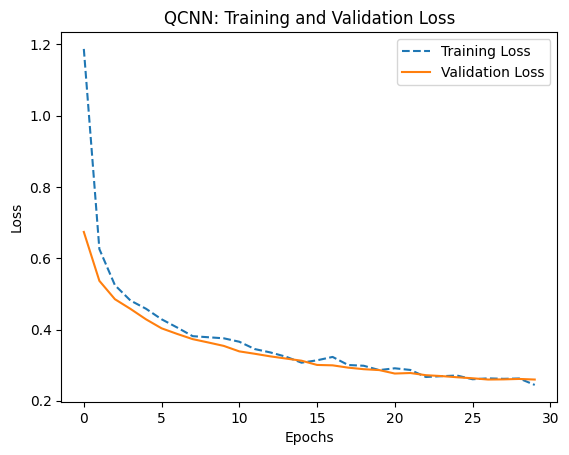

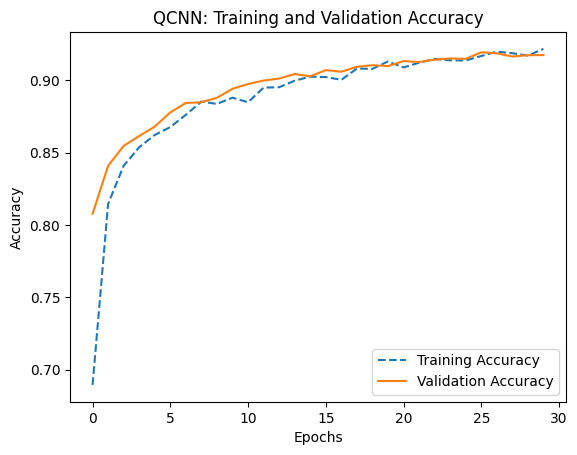

In [ ]:
# Plot training loss and validation loss
plt.plot(qcnn_history.history['loss'], label='Training Loss', linestyle='dashed')
plt.plot(qcnn_history.history['val_loss'], label='Validation Loss', linestyle='solid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("QCNN: Training and Validation Loss")
plt.show()

# Plot training loss and validation accuracy
plt.plot(qcnn_history.history['accuracy'], label='Training Accuracy', linestyle='dashed')
plt.plot(qcnn_history.history['val_accuracy'], label='Validation Accuracy', linestyle='solid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("QCNN: Training and Validation Accuracy")
plt.show()

### Comparing both CNN and QCNN together

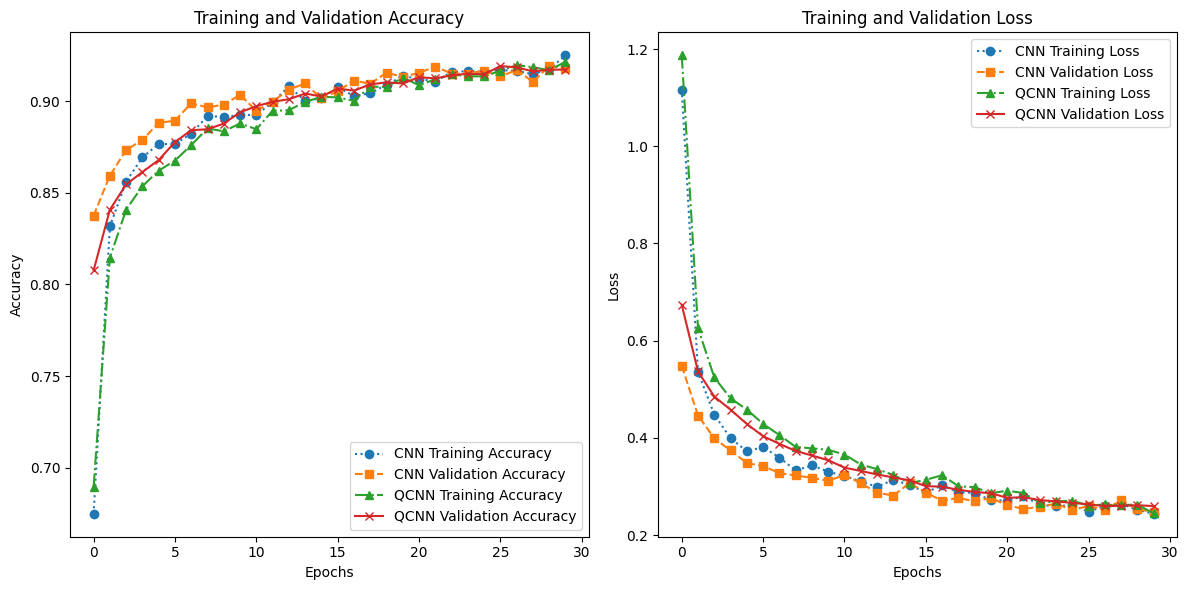

In [ ]:
def plot_metrics(cnn_history, qcnn_history):
    plt.figure(figsize=(12, 6))

    # Training and Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy', linestyle='dotted', marker='o')
    plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy', linestyle='dashed', marker='s')
    plt.plot(qcnn_history.history['accuracy'], label='QCNN Training Accuracy', linestyle='dashdot', marker='^')
    plt.plot(qcnn_history.history['val_accuracy'], label='QCNN Validation Accuracy', linestyle='solid', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Training and Validation Accuracy")

    # Training and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(cnn_history.history['loss'], label='CNN Training Loss', linestyle='dotted', marker='o')
    plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss', linestyle='dashed', marker='s')
    plt.plot(qcnn_history.history['loss'], label='QCNN Training Loss', linestyle='dashdot', marker='^')
    plt.plot(qcnn_history.history['val_loss'], label='QCNN Validation Loss', linestyle='solid', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()

plot_metrics(cnn_history, qcnn_history)

In [ ]:
import pandas as pd

def show_results_table(cnn_history, qcnn_history):
    results = pd.DataFrame({
        'Metric': ['Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss'],
        'CNN': [cnn_history.history['accuracy'][-1], cnn_history.history['val_accuracy'][-1],
                cnn_history.history['loss'][-1], cnn_history.history['val_loss'][-1]],
        'QCNN': [qcnn_history.history['accuracy'][-1], qcnn_history.history['val_accuracy'][-1],
                 qcnn_history.history['loss'][-1], qcnn_history.history['val_loss'][-1]]
    })

    print(results)

# Assuming you have cnn_history and qcnn_history defined somewhere
show_results_table(cnn_history, qcnn_history)


                Metric       CNN      QCNN
0    Training Accuracy  0.925096  0.921538
1  Validation Accuracy  0.918100  0.917300
2        Training Loss  0.243667  0.244503
3      Validation Loss  0.246792  0.259600


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4029068e-263e-4c12-9932-d3ac72036324' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>